# Modeling

In [1]:
# Set up environment

import unicodedata
import re
import json

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# matplotlib default plotting styles
plt.rc("patch", edgecolor="black", force_edgecolor=True)
plt.rc("axes", grid=True)
plt.rc("grid", linestyle=":", linewidth=0.8, alpha=0.7)
plt.rc("axes.spines", right=False, top=False)
plt.rc("figure", figsize=(11, 8))
plt.rc("font", size=12.0)
plt.rc("hist", bins=25)

import warnings
warnings.filterwarnings('ignore')

import acquire

## Acquire

In [2]:
original_df = acquire.get_news_articles()

In [3]:
original_df.head(3)

,Unnamed: 0,author,category,content,published_date,title
0,0,Pragya Swastik,business,Former Finance Minister P Chidambaram on Thurs...,2019-12-05T10:41:04.000Z,"8, 7, 6.6, 5.8, 5 & 4.5 is the state of econom..."
1,1,Kanishka Pandey,business,Google's 47-year-old India-born CEO Sundar Pic...,2019-12-06T03:32:57.000Z,Sundar Pichai rejected Google shares worth mil...
2,2,Kanishka Pandey,business,Google Co-founders Sergey Brin and Larry Page ...,2019-12-05T06:36:23.000Z,Google Co-founders gain $2.3B after Sundar Pic...


In [4]:
original_df.drop(columns = 'Unnamed: 0', inplace = True)

In [5]:
original_df.columns = ['author', 'category', 'body', 'published_date', 'title']

In [6]:
df = original_df[['body', 'category']]

## Prepare

Normalize text

- Convert to all lowercase
- Normalize the unicode characters
- Remove any non-alpha or whitespace characters
- Remove any alpha strings with 2 characters or less

In [7]:
def basic_clean(string):
    """
    Lowercase the string
    Normalize unicode characters
    Replace anything that is not a letter, number, whitespace or a single quote.
    """
    string = string.lower()
    string = unicodedata.normalize('NFKD', string).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    # remove anything not a space character, an apostrophy, letter, or number
    string = re.sub(r"[^a-z]", ' ', string)
    
    string = re.sub(r'\b[a-z]{,2}\b', '', string)

    # convert newlins and tabs to a single space
    string = re.sub(r'[\r|\n|\r\n]+', ' ', string)
    string = string.strip()
    return string

### Stem

In [8]:
def tokenize(string):
    tokenizer = nltk.tokenize.ToktokTokenizer()
    return tokenizer.tokenize(string, return_str=True)

### Lemmatize

In [9]:
def stem(string):
    ps = nltk.porter.PorterStemmer()
    stems = [ps.stem(word) for word in string.split()]
    string_of_stems = ' '.join(stems)
    return string_of_stems


### Tokenize

In [10]:
def lemmatize(string):
    wnl = nltk.stem.WordNetLemmatizer()
    lemmas = [wnl.lemmatize(word) for word in string.split()]
    string_of_lemmas = ' '.join(lemmas)
    return string_of_lemmas


### Remove Stopwords

In [11]:
def remove_stopwords(string, extra_words=[], exclude_words=[]):
    # Tokenize the string
    string = tokenize(string)

    words = string.split()
    stopword_list = stopwords.words('english')

    # remove the excluded words from the stopword list
    stopword_list = set(stopword_list) - set(exclude_words)

    # add in the user specified extra words
    stopword_list = stopword_list.union(set(extra_words))

    filtered_words = [w for w in words if w not in stopword_list]
    final_string = " ".join(filtered_words)
    return final_string


In [12]:
def prep_articles(df):
    df["original"] = df.body
    df["stemmed"] = df.body.apply(basic_clean).apply(stem)
    df["lemmatized"] = df.body.apply(basic_clean).apply(lemmatize)
    df["cleaned"] = df.body.apply(basic_clean).apply(remove_stopwords)
    df.drop(columns=["body"], inplace=True)
    return df

In [13]:
df = prep_articles(df)

In [14]:
df.head()

,category,original,stemmed,lemmatized,cleaned
0,business,Former Finance Minister P Chidambaram on Thurs...,former financ minist chidambaram thursday said...,former finance minister chidambaram thursday s...,former finance minister chidambaram thursday s...
1,business,Google's 47-year-old India-born CEO Sundar Pic...,googl year old india born ceo sundar pichai re...,google year old india born ceo sundar pichai r...,google year old india born ceo sundar pichai r...
2,business,Google Co-founders Sergey Brin and Larry Page ...,googl founder sergey brin and larri page ad co...,google founder sergey brin and larry page adde...,google founders sergey brin larry page added c...
3,business,"SoftBank Founder and CEO Masayoshi Son, in a d...",softbank founder and ceo masayoshi son discuss...,softbank founder and ceo masayoshi son discuss...,softbank founder ceo masayoshi son discussion ...
4,business,Nirav Modi has been declared a fugitive econom...,nirav modi ha been declar fugit econom offend ...,nirav modi ha been declared fugitive economic ...,nirav modi declared fugitive economic offender...


## Prep Summary

- Cleaned data and category in new data frame

In [15]:
df = df[['category', 'cleaned']]

In [16]:
df.head()

,category,cleaned
0,business,former finance minister chidambaram thursday s...
1,business,google year old india born ceo sundar pichai r...
2,business,google founders sergey brin larry page added c...
3,business,softbank founder ceo masayoshi son discussion ...
4,business,nirav modi declared fugitive economic offender...


## Explore & Define Features

### Category Distribution

In [17]:
df.category.value_counts(normalize = True)

business         0.25
technology       0.25
sports           0.25
entertainment    0.25
Name: category, dtype: float64

In [18]:
pd.concat(
    [df.category.value_counts(), df.category.value_counts(normalize = True)],
    axis = 1).set_axis(['n', 'percent'], axis = 1, inplace = False)

,n,percent
business,25,0.25
technology,25,0.25
sports,25,0.25
entertainment,25,0.25


,n,percent
business,25,0.25
technology,25,0.25
sports,25,0.25
entertainment,25,0.25


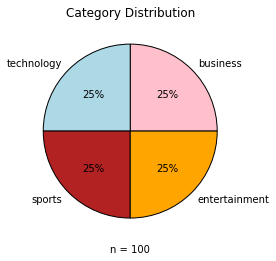

In [19]:
df.category.value_counts().plot.pie(
    colors = ['pink', 'lightblue', 'firebrick', 'orange'], autopct = '%.0f%%')
plt.title("Category Distribution")
plt.ylabel("")
plt.xlabel('n = %d' % df.shape[0])

pd.concat(
    [df.category.value_counts(), df.category.value_counts(normalize = True)], axis = 1).set_axis(["n", "percent"], axis = 1, inplace = False)

### Term Frequency

Generally, when you hear 'Term Frequency', it is referring to the number of documents in which a word appears.
When we move on to computing TF-IDF, this basic definition of Term Frequency applies.

However, term frequency can be calculated in a number of ways, all of which reflect how frequently a word appears in a document.

- Raw Count: This is simply the count of the number of occurances of each word.
- Frequency: The number of times each word appears divided by the total number of words.
- Augmented Frequency: The frequency of each word divided by the maximum frequency. This can help prevent bias towards larger documents.

In [21]:
pd.Series(" ".join(df.cleaned).split()).value_counts().head(10)

said          76
india         36
added         36
year          21
google        21
ceo           17
first         15
billion       15
bank          14
government    13
dtype: int64

In [43]:
all_words = ' '.join(df.cleaned).split()
business_words = ' '.join(df[df.category == 'business'].cleaned).split()
entertainment_words = ' '.join(df[df.category == 'entertainment'].cleaned).split()
technology_words = ' '.join(df[df.category == 'technology'].cleaned).split()
sports_words = ' '.join(df[df.category == 'sports'].cleaned).split()

- Once we have a list of words, we can transform it into a pandas Series, which we can then use to show us how often each of the words occurs.

In [44]:
all_freq = pd.Series(all_words).value_counts()
business_words_freq = pd.Series(business_words).value_counts()
entertainment_words_freq = pd.Series(entertainment_words).value_counts()
technology_words_freq = pd.Series(technology_words).value_counts()
sports_words_freq = pd.Series(sports_words).value_counts()

In [46]:
word_counts = (pd.concat([all_freq, business_words_freq, entertainment_words_freq, technology_words_freq, sports_words_freq], axis=1, sort=True)
                .set_axis(['all', 'business', 'entertainment', 'technology', 'sports'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

In [49]:
word_counts.head().T

,aaliyah,aamir,aaye,abdul,ability
all,1,1,2,2,1
business,0,0,0,0,0
entertainment,1,1,2,0,0
technology,0,0,0,0,0
sports,0,0,0,2,1


In [50]:
tf = (
    pd.concat([all_freq, business_words_freq, entertainment_words_freq, technology_words_freq, sports_words_freq], axis=1, sort=True)
    .rename(columns={0: "all", 1: "business", 2: "entertainment", 3: "technology", 4: "sports"})
    .fillna(0)
    .apply(lambda col: col.astype(int))
)

In [53]:
tf.T

,aaliyah,aamir,aaye,abdul,ability,able,absolutely,abuse,abusing,accelerate,...,year,years,yellow,yet,york,young,younis,youth,youtube,yuvraj
all,1,1,2,2,1,1,1,1,1,1,...,21,6,1,2,3,2,1,1,3,1
business,0,0,0,0,0,0,0,0,0,0,...,9,2,0,1,1,0,0,0,0,0
entertainment,1,1,2,0,0,0,0,0,0,0,...,4,1,0,1,1,0,0,0,0,0
technology,0,0,0,0,0,1,0,1,1,1,...,3,1,1,0,1,0,0,0,3,0
sports,0,0,0,2,1,0,1,0,0,0,...,5,2,0,0,0,2,1,1,0,1


- most common words overall?
- most common business, entertainment, technology, sports words?
- any words that uniquely business, entertainment, technology, sports words?

In [56]:
tf.sort_values(by="all").tail(10)

,all,business,entertainment,technology,sports
government,13,7,1,5,0
bank,14,13,0,1,0
first,15,2,3,3,7
billion,15,9,0,6,0
ceo,17,9,0,8,0
year,21,9,4,3,5
google,21,7,0,14,0
added,36,6,13,2,15
india,36,10,2,9,15
said,76,21,23,14,18


Text(0.5, 1.0, '10 most common words')

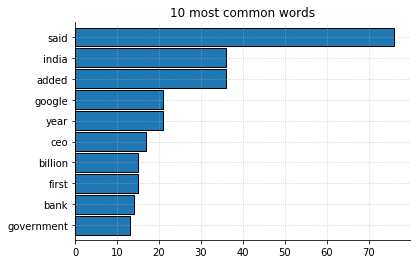

In [57]:
tf.sort_values(by='all')['all'].tail(10).plot.barh(width=.9)
plt.title('10 most common words')

Text(0.5, 1.0, '10 most common business words')

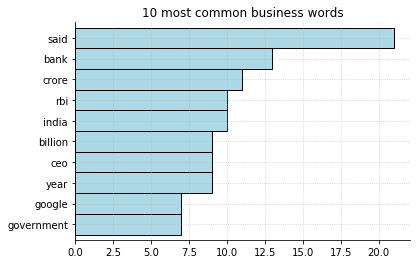

In [67]:
tf.sort_values(by='business').business.tail(10).plot.barh(width=1, color='lightblue')
plt.title('10 most common business words')

Text(0.5, 1.0, 'What are the most common entertainment words')

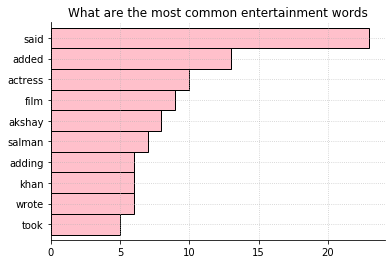

In [59]:
tf.sort_values(by='entertainment').entertainment.tail(10).plot.barh(width=1, color='pink')
plt.title('What are the most common entertainment words')

Text(0.5, 1.0, 'What are the most common technology words')

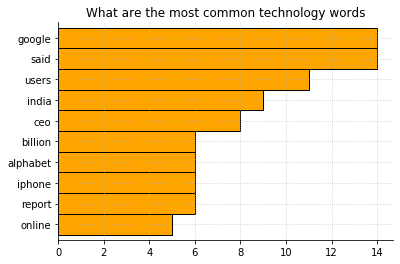

In [66]:
tf.sort_values(by='technology').technology.tail(10).plot.barh(width=1, color='orange')
plt.title('What are the most common technology words')

Text(0.5, 1.0, 'What are the most common sports words')

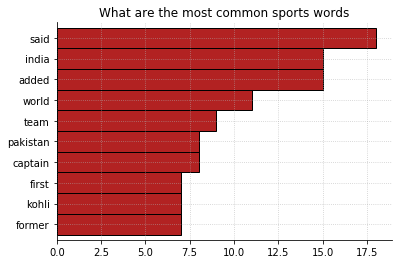

In [65]:
tf.sort_values(by='sports').sports.tail(10).plot.barh(width=1, color='firebrick')
plt.title('What are the most common sports words')